## The Transformer Network for the Traveling Salesman Problem

Xavier Bresson, Thomas Laurent, Feb 2021<br>

Arxiv : https://arxiv.org/pdf/2103.03012.pdf<br>
Talk : https://ipam.wistia.com/medias/0jrweluovs<br>
Slides : https://t.co/ySxGiKtQL5<br>

This code trains the transformer network by reinforcement learning.<br>
Use the beam search code to test the trained network.


In [1]:
###################
# Libs
###################

import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
try: 
    import networkx as nx
    from scipy.spatial.distance import pdist, squareform
    from concorde.tsp import TSPSolver # !pip install -e pyconcorde
except:
    pass
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


/tmp/ipykernel_18942/2912911153.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png2x','pdf')


In [2]:
###################
# Hardware : CPU / GPU(s)
###################
if "TSP" not in os.getcwd():
    os.chdir("TSP_Transformer")
print(os.getcwd())
device = torch.device("cpu"); gpu_id = -1 # select CPU

#gpu_id = '0' # select a single GPU  
gpu_id = '0,1' # select multiple GPUs  
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)


/teamspace/studios/this_studio/TSP_Transformer
GPU name: Tesla T4, gpu_id: 0,1
cuda


In [3]:
###################
# Hyper-parameters
###################

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self
        
args = DotDict()
args.nb_nodes = 20 # TSP20
args.nb_nodes = 50 # TSP50
args.nb_nodes = 100 # TSP100
args.bsz = 512 #512 TSP20 TSP50
args.dim_emb = 128
args.dim_ff = 512
args.dim_input_nodes = 2
args.nb_layers_encoder = 6
args.nb_layers_decoder = 2
args.nb_heads = 8
args.nb_epochs = 10000
args.nb_batch_per_epoch = 1500#2500
args.nb_batch_eval = 20
args.gpu_id = gpu_id
args.lr = 1e-4
args.tol = 1e-3
args.batchnorm = True  # if batchnorm=True  than batch norm is used
#args.batchnorm = False # if batchnorm=False than layer norm is used
args.max_len_PE = 1000

print(args)


{'nb_nodes': 100, 'bsz': 256, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 10000, 'nb_batch_per_epoch': 1500, 'nb_batch_eval': 20, 'gpu_id': '0,1', 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}


In [4]:
###################
# Small test set for quick algorithm comparison
# Note : this can be removed
###################

save_1000tsp = True
save_1000tsp = False
if save_1000tsp:
    bsz = 1000
    x = torch.rand(bsz, args.nb_nodes, args.dim_input_nodes, device='cpu') 
    print(x.size(),x[0])
    data_dir = os.path.join("data")
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if args.nb_nodes==20 : torch.save({ 'x': x, }, '{}.pkl'.format(data_dir + "/1000tsp20"))
    if args.nb_nodes==50 : torch.save({ 'x': x, }, '{}.pkl'.format(data_dir + "/1000tsp50"))
    if args.nb_nodes==100 : torch.save({ 'x': x, }, '{}.pkl'.format(data_dir + "/1000tsp100"))

checkpoint = None
if args.nb_nodes==20 : checkpoint = torch.load("data/1000tsp20.pkl")
if args.nb_nodes==50 : checkpoint = torch.load("data/1000tsp50.pkl")
if args.nb_nodes==100 : checkpoint = torch.load("data/1000tsp100.pkl")
if checkpoint is not None:
    x_1000tsp = checkpoint['x'].to(device)
    n = x_1000tsp.size(1)
    print('nb of nodes :',n)
else:
    x_1000tsp = torch.rand(1000, args.nb_nodes, args.dim_input_nodes, device='cpu')
    n = x_1000tsp.size(1)
    print('nb of nodes :',n)


nb of nodes : 100


In [5]:
###################
# Network definition
# Notation : 
#            bsz : batch size
#            nb_nodes : number of nodes/cities
#            dim_emb : embedding/hidden dimension
#            nb_heads : nb of attention heads
#            dim_ff : feed-forward dimension
#            nb_layers : number of encoder/decoder layers
###################
def compute_tour_length(x, tour): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, nb_nodes, 2) batch of tsp tour instances
             tour of size (bsz, nb_nodes) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    bsz = x.shape[0]
    nb_nodes = x.shape[1]
    arange_vec = torch.arange(bsz, device=x.device)
    first_cities = x[arange_vec, tour[:,0], :] # size(first_cities)=(bsz,2)
    previous_cities = first_cities
    L = torch.zeros(bsz, device=x.device)
    with torch.no_grad():
        for i in range(1,nb_nodes):
            current_cities = x[arange_vec, tour[:,i], :] 
            L += torch.sum( (current_cities - previous_cities)**2 , dim=1 )**0.5 # dist(current, previous node) 
            previous_cities = current_cities
        L += torch.sum( (current_cities - first_cities)**2 , dim=1 )**0.5 # dist(last, first node)  
    return L


class Transformer_encoder_net(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes+1, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes+1, nb_nodes+1) batch of attention scores
    """
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(Transformer_encoder_net, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

def myMHA(Q, K, V, nb_heads, mask=None, clip_value=None):
    """
    Compute multi-head attention (MHA) given a query Q, key K, value V and attention mask :
      h = Concat_{k=1}^nb_heads softmax(Q_k^T.K_k).V_k 
    Note : We did not use nn.MultiheadAttention to avoid re-computing all linear transformations at each call.
    Inputs : Q of size (bsz, dim_emb, 1)                batch of queries
             K of size (bsz, dim_emb, nb_nodes+1)       batch of keys
             V of size (bsz, dim_emb, nb_nodes+1)       batch of values
             mask of size (bsz, nb_nodes+1)             batch of masks of visited cities
             clip_value is a scalar 
    Outputs : attn_output of size (bsz, 1, dim_emb)     batch of attention vectors
              attn_weights of size (bsz, 1, nb_nodes+1) batch of attention weights
    """
    bsz, nb_nodes, emd_dim = K.size() #  dim_emb must be divisable by nb_heads
    if nb_heads>1:
        # PyTorch view requires contiguous dimensions for correct reshaping
        Q = Q.transpose(1,2).contiguous() # size(Q)=(bsz, dim_emb, 1)
        Q = Q.view(bsz*nb_heads, emd_dim//nb_heads, 1) # size(Q)=(bsz*nb_heads, dim_emb//nb_heads, 1)
        Q = Q.transpose(1,2).contiguous() # size(Q)=(bsz*nb_heads, 1, dim_emb//nb_heads)
        K = K.transpose(1,2).contiguous() # size(K)=(bsz, dim_emb, nb_nodes+1)
        K = K.view(bsz*nb_heads, emd_dim//nb_heads, nb_nodes) # size(K)=(bsz*nb_heads, dim_emb//nb_heads, nb_nodes+1)
        K = K.transpose(1,2).contiguous() # size(K)=(bsz*nb_heads, nb_nodes+1, dim_emb//nb_heads)
        V = V.transpose(1,2).contiguous() # size(V)=(bsz, dim_emb, nb_nodes+1)
        V = V.view(bsz*nb_heads, emd_dim//nb_heads, nb_nodes) # size(V)=(bsz*nb_heads, dim_emb//nb_heads, nb_nodes+1)
        V = V.transpose(1,2).contiguous() # size(V)=(bsz*nb_heads, nb_nodes+1, dim_emb//nb_heads)
    attn_weights = torch.bmm(Q, K.transpose(1,2))/ Q.size(-1)**0.5 # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    if clip_value is not None:
        attn_weights = clip_value * torch.tanh(attn_weights)
    if mask is not None:
        if nb_heads>1:
            mask = torch.repeat_interleave(mask, repeats=nb_heads, dim=0) # size(mask)=(bsz*nb_heads, nb_nodes+1)
        #attn_weights = attn_weights.masked_fill(mask.unsqueeze(1), float('-inf')) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
        attn_weights = attn_weights.masked_fill(mask.unsqueeze(1), float('-1e9')) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    attn_weights = torch.softmax(attn_weights, dim=-1) # size(attn_weights)=(bsz*nb_heads, 1, nb_nodes+1)
    attn_output = torch.bmm(attn_weights, V) # size(attn_output)=(bsz*nb_heads, 1, dim_emb//nb_heads)
    if nb_heads>1:
        attn_output = attn_output.transpose(1,2).contiguous() # size(attn_output)=(bsz*nb_heads, dim_emb//nb_heads, 1)
        attn_output = attn_output.view(bsz, emd_dim, 1) # size(attn_output)=(bsz, dim_emb, 1)
        attn_output = attn_output.transpose(1,2).contiguous() # size(attn_output)=(bsz, 1, dim_emb)
        attn_weights = attn_weights.view(bsz, nb_heads, 1, nb_nodes) # size(attn_weights)=(bsz, nb_heads, 1, nb_nodes+1)
        attn_weights = attn_weights.mean(dim=1) # mean over the heads, size(attn_weights)=(bsz, 1, nb_nodes+1)
    return attn_output, attn_weights
    
    
class AutoRegressiveDecoderLayer(nn.Module):
    """
    Single decoder layer based on self-attention and query-attention
    Inputs :  
      h_t of size      (bsz, 1, dim_emb)          batch of input queries
      K_att of size    (bsz, nb_nodes+1, dim_emb) batch of query-attention keys
      V_att of size    (bsz, nb_nodes+1, dim_emb) batch of query-attention values
      mask of size     (bsz, nb_nodes+1)          batch of masks of visited cities
    Output :  
      h_t of size (bsz, nb_nodes+1)               batch of transformed queries
    """
    def __init__(self, dim_emb, nb_heads):
        super(AutoRegressiveDecoderLayer, self).__init__()
        self.dim_emb = dim_emb
        self.nb_heads = nb_heads
        self.Wq_selfatt = nn.Linear(dim_emb, dim_emb)
        self.Wk_selfatt = nn.Linear(dim_emb, dim_emb)
        self.Wv_selfatt = nn.Linear(dim_emb, dim_emb)
        self.W0_selfatt = nn.Linear(dim_emb, dim_emb)
        self.W0_att = nn.Linear(dim_emb, dim_emb)
        self.Wq_att = nn.Linear(dim_emb, dim_emb)
        self.W1_MLP = nn.Linear(dim_emb, dim_emb)
        self.W2_MLP = nn.Linear(dim_emb, dim_emb)
        self.BN_selfatt = nn.LayerNorm(dim_emb)
        self.BN_att = nn.LayerNorm(dim_emb)
        self.BN_MLP = nn.LayerNorm(dim_emb)
        self.K_sa = None
        self.V_sa = None

    def reset_selfatt_keys_values(self):
        self.K_sa = None
        self.V_sa = None
        
    def forward(self, h_t, K_att, V_att, mask):
        bsz = h_t.size(0)
        h_t = h_t.view(bsz,1,self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # embed the query for self-attention
        q_sa = self.Wq_selfatt(h_t) # size(q_sa)=(bsz, 1, dim_emb)
        k_sa = self.Wk_selfatt(h_t) # size(k_sa)=(bsz, 1, dim_emb)
        v_sa = self.Wv_selfatt(h_t) # size(v_sa)=(bsz, 1, dim_emb)
        # concatenate the new self-attention key and value to the previous keys and values
        if self.K_sa is None:
            self.K_sa = k_sa # size(self.K_sa)=(bsz, 1, dim_emb)
            self.V_sa = v_sa # size(self.V_sa)=(bsz, 1, dim_emb)
        else:
            self.K_sa = torch.cat([self.K_sa, k_sa], dim=1)
            self.V_sa = torch.cat([self.V_sa, v_sa], dim=1)
        # compute self-attention between nodes in the partial tour
        h_t = h_t + self.W0_selfatt( myMHA(q_sa, self.K_sa, self.V_sa, self.nb_heads)[0] ) # size(h_t)=(bsz, 1, dim_emb)
        h_t = self.BN_selfatt(h_t.squeeze()) # size(h_t)=(bsz, dim_emb)
        h_t = h_t.view(bsz, 1, self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # compute attention between self-attention nodes and encoding nodes in the partial tour (translation process)
        q_a = self.Wq_att(h_t) # size(q_a)=(bsz, 1, dim_emb)
        h_t = h_t + self.W0_att( myMHA(q_a, K_att, V_att, self.nb_heads, mask)[0] ) # size(h_t)=(bsz, 1, dim_emb)
        h_t = self.BN_att(h_t.squeeze()) # size(h_t)=(bsz, dim_emb)
        h_t = h_t.view(bsz, 1, self.dim_emb) # size(h_t)=(bsz, 1, dim_emb)
        # MLP
        h_t = h_t + self.W2_MLP(torch.relu(self.W1_MLP(h_t)))
        h_t = self.BN_MLP(h_t.squeeze(1)) # size(h_t)=(bsz, dim_emb)
        return h_t
        
        
class Transformer_decoder_net(nn.Module): 
    """
    Decoder network based on self-attention and query-attention transformers
    Inputs :  
      h_t of size      (bsz, 1, dim_emb)                            batch of input queries
      K_att of size    (bsz, nb_nodes+1, dim_emb*nb_layers_decoder) batch of query-attention keys for all decoding layers
      V_att of size    (bsz, nb_nodes+1, dim_emb*nb_layers_decoder) batch of query-attention values for all decoding layers
      mask of size     (bsz, nb_nodes+1)                            batch of masks of visited cities
    Output :  
      prob_next_node of size (bsz, nb_nodes+1)                      batch of probabilities of next node
    """
    def __init__(self, dim_emb, nb_heads, nb_layers_decoder):
        super(Transformer_decoder_net, self).__init__()
        self.dim_emb = dim_emb
        self.nb_heads = nb_heads
        self.nb_layers_decoder = nb_layers_decoder
        self.decoder_layers = nn.ModuleList( [AutoRegressiveDecoderLayer(dim_emb, nb_heads) for _ in range(nb_layers_decoder-1)] )
        self.Wq_final = nn.Linear(dim_emb, dim_emb)
        
    # Reset to None self-attention keys and values when decoding starts 
    def reset_selfatt_keys_values(self): 
        for l in range(self.nb_layers_decoder-1):
            self.decoder_layers[l].reset_selfatt_keys_values()
            
    def forward(self, h_t, K_att, V_att, mask):
        for l in range(self.nb_layers_decoder):
            K_att_l = K_att[:,:,l*self.dim_emb:(l+1)*self.dim_emb].contiguous()  # size(K_att_l)=(bsz, nb_nodes+1, dim_emb)
            V_att_l = V_att[:,:,l*self.dim_emb:(l+1)*self.dim_emb].contiguous()  # size(V_att_l)=(bsz, nb_nodes+1, dim_emb)
            if l<self.nb_layers_decoder-1: # decoder layers with multiple heads (intermediate layers)
                h_t = self.decoder_layers[l](h_t, K_att_l, V_att_l, mask)
            else: # decoder layers with single head (final layer)
                q_final = self.Wq_final(h_t)
                bsz = h_t.size(0)
                q_final = q_final.view(bsz, 1, self.dim_emb)
                attn_weights = myMHA(q_final, K_att_l, V_att_l, 1, mask, 10)[1] 
        prob_next_node = attn_weights.squeeze(1) 
        return prob_next_node


def generate_positional_encoding(d_model, max_len):
    """
    Create standard transformer PEs.
    Inputs :  
      d_model is a scalar correspoding to the hidden dimension
      max_len is the maximum length of the sequence
    Output :  
      pe of size (max_len, d_model), where d_model=dim_emb, max_len=1000
    """
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    pe[:,0::2] = torch.sin(position * div_term)
    pe[:,1::2] = torch.cos(position * div_term)
    return pe
    
    
class TSP_net(nn.Module): 
    """
    The TSP network is composed of two steps :
      Step 1. Encoder step : Take a set of 2D points representing a fully connected graph 
                             and encode the set with self-transformer.
      Step 2. Decoder step : Build the TSP tour recursively/autoregressively, 
                             i.e. one node at a time, with a self-transformer and query-transformer. 
    Inputs : 
      x of size (bsz, nb_nodes, dim_emb) Euclidian coordinates of the nodes/cities
      deterministic is a boolean : If True the salesman will chose the city with highest probability. 
                                   If False the salesman will chose the city with Bernouilli sampling.
    Outputs : 
      tours of size (bsz, nb_nodes) : batch of tours, i.e. sequences of ordered cities 
                                      tours[b,t] contains the idx of the city visited at step t in batch b
      sumLogProbOfActions of size (bsz,) : batch of sum_t log prob( pi_t | pi_(t-1),...,pi_0 )
    """
    
    def __init__(self, dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,
                 batchnorm=True):
        super(TSP_net, self).__init__()
        
        self.dim_emb = dim_emb
        
        # input embedding layer
        self.input_emb = nn.Linear(dim_input_nodes, dim_emb)
        
        # encoder layer
        self.encoder = Transformer_encoder_net(nb_layers_encoder, dim_emb, nb_heads, dim_ff, batchnorm)
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(dim_emb))
        
        # decoder layer
        self.decoder = Transformer_decoder_net(dim_emb, nb_heads, nb_layers_decoder)
        self.WK_att_decoder = nn.Linear(dim_emb, nb_layers_decoder* dim_emb) 
        self.WV_att_decoder = nn.Linear(dim_emb, nb_layers_decoder* dim_emb) 
        self.PE = generate_positional_encoding(dim_emb, max_len_PE)        
        
    def forward(self, x, deterministic=False):

        # some parameters
        bsz = x.shape[0]
        nb_nodes = x.shape[1]
        zero_to_bsz = torch.arange(bsz, device=x.device) # [0,1,...,bsz-1]

        # input embedding layer
        h = self.input_emb(x) # size(h)=(bsz, nb_nodes, dim_emb)
        
        # concat the nodes and the input placeholder that starts the decoding
        h = torch.cat([h, self.start_placeholder.repeat(bsz, 1, 1)], dim=1) # size(start_placeholder)=(bsz, nb_nodes+1, dim_emb)
        
        # encoder layer
        h_encoder, _ = self.encoder(h) # size(h)=(bsz, nb_nodes+1, dim_emb)

        # list that will contain Long tensors of shape (bsz,) that gives the idx of the cities chosen at time t
        tours = []

        # list that will contain Float tensors of shape (bsz,) that gives the neg log probs of the choices made at time t
        sumLogProbOfActions = []

        # key and value for decoder    
        K_att_decoder = self.WK_att_decoder(h_encoder) # size(K_att)=(bsz, nb_nodes+1, dim_emb*nb_layers_decoder)
        V_att_decoder = self.WV_att_decoder(h_encoder) # size(V_att)=(bsz, nb_nodes+1, dim_emb*nb_layers_decoder)
        
        # input placeholder that starts the decoding
        self.PE = self.PE.to(x.device)
        idx_start_placeholder = torch.Tensor([nb_nodes]).long().repeat(bsz).to(x.device)
        h_start = h_encoder[zero_to_bsz, idx_start_placeholder, :] + self.PE[0].repeat(bsz,1) # size(h_start)=(bsz, dim_emb)
        
        # initialize mask of visited cities
        mask_visited_nodes = torch.zeros(bsz, nb_nodes+1, device=x.device).bool() # False
        mask_visited_nodes[zero_to_bsz, idx_start_placeholder] = True
        
        # clear key and val stored in the decoder
        self.decoder.reset_selfatt_keys_values()

        # construct tour recursively
        h_t = h_start
        for t in range(nb_nodes):
            
            # compute probability over the next node in the tour
            prob_next_node = self.decoder(h_t, K_att_decoder, V_att_decoder, mask_visited_nodes) # size(prob_next_node)=(bsz, nb_nodes+1)
            
            # choose node with highest probability or sample with Bernouilli 
            if deterministic:
                idx = torch.argmax(prob_next_node, dim=1) # size(query)=(bsz,)
            else:
                idx = Categorical(prob_next_node).sample() # size(query)=(bsz,)
            
            # compute logprobs of the action items in the list sumLogProbOfActions   
            ProbOfChoices = prob_next_node[zero_to_bsz, idx] 
            sumLogProbOfActions.append( torch.log(ProbOfChoices) )  # size(query)=(bsz,)

            # update embedding of the current visited node
            h_t = h_encoder[zero_to_bsz, idx, :] # size(h_start)=(bsz, dim_emb)
            h_t = h_t + self.PE[t+1].expand(bsz, self.dim_emb)
            
            # update tour
            tours.append(idx)

            # update masks with visited nodes
            mask_visited_nodes = mask_visited_nodes.clone()
            mask_visited_nodes[zero_to_bsz, idx] = True
            
            
        # logprob_of_choices = sum_t log prob( pi_t | pi_(t-1),...,pi_0 )
        sumLogProbOfActions = torch.stack(sumLogProbOfActions,dim=1).sum(dim=1) # size(sumLogProbOfActions)=(bsz,)

        # convert the list of nodes into a tensor of shape (bsz,num_cities)
        tours = torch.stack(tours,dim=1) # size(col_index)=(bsz, nb_nodes)
        
        return tours, sumLogProbOfActions
    
    
    

###################
# Instantiate a training network and a baseline network
###################
try: 
    del model_train # remove existing model
    del model_baseline # remove existing model
except:
    pass

model_train = TSP_net(args.dim_input_nodes, args.dim_emb, args.dim_ff, 
              args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, args.max_len_PE,
              batchnorm=args.batchnorm)

model_baseline = TSP_net(args.dim_input_nodes, args.dim_emb, args.dim_ff, 
              args.nb_layers_encoder, args.nb_layers_decoder, args.nb_heads, args.max_len_PE,
              batchnorm=args.batchnorm)

# uncomment these lines if trained with multiple GPUs
print(torch.cuda.device_count())
if torch.cuda.device_count()>1:
    model_train = nn.DataParallel(model_train)
    model_baseline = nn.DataParallel(model_baseline)
# uncomment these lines if trained with multiple GPUs

optimizer = torch.optim.Adam( model_train.parameters() , lr = args.lr ) 

model_train = model_train.to(device)
model_baseline = model_baseline.to(device)
model_baseline.eval()

print(args); print('')

# Logs
os.system("mkdir logs")
time_stamp=datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S")
file_name = 'logs'+'/'+time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id) + ".txt"
file = open(file_name,"w",1) 
file.write(time_stamp+'\n\n') 
for arg in vars(args):
    file.write(arg)
    hyper_param_val="={}".format(getattr(args, arg))
    file.write(hyper_param_val)
    file.write('\n')
file.write('\n\n') 
plot_performance_train = []
plot_performance_baseline = []
all_strings = []
epoch_ckpt = 0
tot_time_ckpt = 0


# # Uncomment these lines to re-start training with saved checkpoint
# checkpoint_file = "checkpoint/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl"
# checkpoint = torch.load(checkpoint_file, map_location=device)
# epoch_ckpt = checkpoint['epoch'] + 1
# tot_time_ckpt = checkpoint['tot_time']
# plot_performance_train = checkpoint['plot_performance_train']
# plot_performance_baseline = checkpoint['plot_performance_baseline']
# model_baseline.load_state_dict(checkpoint['model_baseline'])
# model_train.load_state_dict(checkpoint['model_train'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
# del checkpoint
# # Uncomment these lines to re-start training with saved checkpoint


###################
# Main training loop 
###################
torch.cuda.memory._record_memory_history()
start_training_time = time.time()
print('start train')
for epoch in range(0,args.nb_epochs):
    
    # re-start training with saved checkpoint
    epoch += epoch_ckpt

    ###################
    # Train model for one epoch
    ###################
    start = time.time()
    model_train.train() 

    for step in range(1,args.nb_batch_per_epoch+1):    

        # generate a batch of random TSP instances    
        x = torch.rand(args.bsz, args.nb_nodes, args.dim_input_nodes, device=device) # size(x)=(bsz, nb_nodes, dim_input_nodes) 

        # compute tours for model
        tour_train, sumLogProbOfActions =  model_train(x, deterministic=False) # size(tour_train)=(bsz, nb_nodes), size(sumLogProbOfActions)=(bsz)
      
        # compute tours for baseline
        with torch.no_grad():
            tour_baseline, _ = model_baseline(x, deterministic=True)

        # get the lengths of the tours
        L_train = compute_tour_length(x, tour_train) # size(L_train)=(bsz)
        L_baseline = compute_tour_length(x, tour_baseline) # size(L_baseline)=(bsz)
        
        # backprop
        loss = torch.mean( (L_train - L_baseline)* sumLogProbOfActions )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    time_one_epoch = time.time()-start
    time_tot = time.time()-start_training_time + tot_time_ckpt

        
    ###################
    # Evaluate train model and baseline on 10k random TSP instances
    ###################
    model_train.eval()
    mean_tour_length_train = 0
    mean_tour_length_baseline = 0
    for step in range(0,args.nb_batch_eval):

        # generate a batch of random tsp instances   
        x = torch.rand(args.bsz, args.nb_nodes, args.dim_input_nodes, device=device) 

        # compute tour for model and baseline
        with torch.no_grad():
            tour_train, _ = model_train(x, deterministic=True)
            tour_baseline, _ = model_baseline(x, deterministic=True)
            
        # get the lengths of the tours
        L_train = compute_tour_length(x, tour_train)
        L_baseline = compute_tour_length(x, tour_baseline)

        # L_tr and L_bl are tensors of shape (bsz,). Compute the mean tour length
        mean_tour_length_train += L_train.mean().item()
        mean_tour_length_baseline += L_baseline.mean().item()

    mean_tour_length_train =  mean_tour_length_train/ args.nb_batch_eval
    mean_tour_length_baseline =  mean_tour_length_baseline/ args.nb_batch_eval

    # evaluate train model and baseline and update if train model is better
    update_baseline = mean_tour_length_train+args.tol < mean_tour_length_baseline
    if update_baseline:
        model_baseline.load_state_dict( model_train.state_dict() )

    # Compute TSPs for small test set
    # Note : this can be removed
    with torch.no_grad():
        tour_baseline, _ = model_baseline(x_1000tsp, deterministic=True)
    mean_tour_length_test = compute_tour_length(x_1000tsp, tour_baseline).mean().item()
    
    # For checkpoint
    plot_performance_train.append([ (epoch+1), mean_tour_length_train])
    plot_performance_baseline.append([ (epoch+1), mean_tour_length_baseline])
        
    # Compute optimality gap
    if args.nb_nodes==50: gap_train = mean_tour_length_train/5.692- 1.0
    elif args.nb_nodes==100: gap_train = mean_tour_length_train/7.765- 1.0
    else: gap_train = -1.0
    
    # Print and save in txt file
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_train: {:.3f}, L_base: {:.3f}, L_test: {:.3f}, gap_train(%): {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_train, mean_tour_length_baseline, mean_tour_length_test, 100*gap_train, update_baseline) 
    print(mystring_min) # Comment if plot display
    file.write(mystring_min+'\n')
#     all_strings.append(mystring_min) # Uncomment if plot display
#     for string in all_strings: 
#         print(string)
    
    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'TSP_length': [torch.mean(L_train).item(), torch.mean(L_baseline).item(), mean_tour_length_test],
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'mean_tour_length_test': mean_tour_length_test,
        'model_baseline': model_baseline.state_dict(),
        'model_train': model_train.state_dict(),
        'optimizer': optimizer.state_dict(),
        }, '{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(args.nb_nodes) + "-gpu{}".format(args.gpu_id)))

torch.cuda.memory._dump_snapshot("memory.pickle")

1
{'nb_nodes': 100, 'bsz': 256, 'dim_emb': 128, 'dim_ff': 512, 'dim_input_nodes': 2, 'nb_layers_encoder': 6, 'nb_layers_decoder': 2, 'nb_heads': 8, 'nb_epochs': 10000, 'nb_batch_per_epoch': 1500, 'nb_batch_eval': 20, 'gpu_id': '0,1', 'lr': 0.0001, 'tol': 0.001, 'batchnorm': True, 'max_len_PE': 1000}

start train


mkdir: cannot create directory ‘logs’: File exists


2583.0350987911224
2631.5465240932645


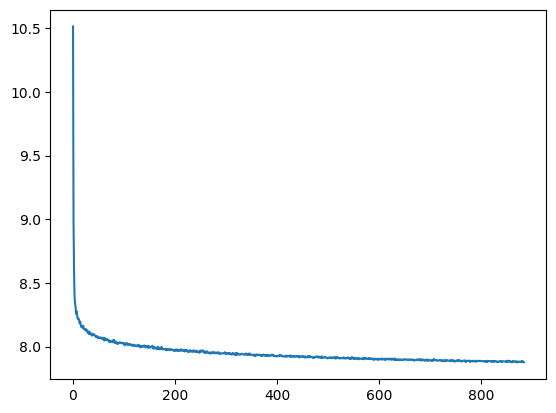

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
#read checkpoint
if "TSP" not in os.getcwd():
    os.chdir("TSP_Transformer")
checkpoint_file = "checkpoint/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl"
checkpoint = torch.load(checkpoint_file,map_location='cpu')
print(checkpoint['time'])
print(checkpoint['tot_time']/checkpoint['epoch'])
plt.plot([x[0] for x in checkpoint['plot_performance_train']], [x[1] for x in checkpoint['plot_performance_train']], label='train')